In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
from astropy.stats import sigma_clip
import os
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.constants import c
c= c*1e-3 #in km/s
import os
import random

# FeII doublet values
from linetools.lists.linelist import LineList
linelist = LineList('ISM', verbose=False)
line1 = linelist['FeII 2374']
fe1 = line1['wrest'].value
line2 = linelist['FeII 2382']
fe2 = line2['wrest'].value
print(f"FeII first doublet = {fe1}\n" f"FeII second doublet = {fe2}\n" f"speed of light in vacuum in km/s = {c}")

#1. 0 - 30
#2. 30- 60
#3. 60- 90
#4. 90- 120
#5. 120- 150
#6. 150-180

#Fluxes and observed wavelengths are expressed in units of 10^−20 erg s−1 cm−2 Å−1 and Å, respectively
#The flux unit of datacubes and white light images is 10^−20 erg s−1 cm−2 Å−1 . 
#Variance is given in the square of the flux unit.

read_sets: Using set file -- 
  /home/mehak-gupta/jupyter-venv/lib/python3.12/site-packages/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
FeII first doublet = 2374.4612
FeII second doublet = 2382.7652
speed of light in vacuum in km/s = 299792.458


In [63]:
# Separation limits (in kpc)
file_index = 14
sep_low = 40
sep_up  = 80
snr= 3.0
# Paths to files and directories
base_path = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /FeII_2374_2382/"
redshift_file   = f'{base_path}redshift_fe.txt'
background_dir  = base_path
normalized_dir  = f'{base_path}normalized_output{file_index}'
accepted_dir    = f'{base_path}accepted_output{file_index}'

# Creating output directories if they don't exist
os.makedirs(normalized_dir, exist_ok=True)
os.makedirs(accepted_dir, exist_ok=True)

# Reading the redshift file (skip header)
redshift_data = np.loadtxt(redshift_file, skiprows=1)

# Lists to store accepted rows of bg sources and median S/N values
accepted_rows     = []
accepted_median_sn = []

# Processing Each Row from redshift.txt (file having ids, zfore and separation)
rejected=0
for row in redshift_data:
    # Unpacking the redshift row:
    id_bg, id_fg, redshift_fore, mass_fore, sfr_fore, separation = row

    # Checking if separation is within the desired range.
    if (separation > sep_low) and (separation <= sep_up):
        bg_spec = os.path.join(background_dir, f"{int(id_bg)}.txt")
        
        # Checking if the background spectrum file exists
        if not os.path.exists(bg_spec):
            print(f"File {bg_spec} not found. Skipping background ID {int(id_bg)}.")
            continue

        # Loading the background spectrum file
        spectrum = np.loadtxt(bg_spec, skiprows=1,usecols=(0, 1, 2))
        
        # Extracting columns from the background spectrum:
        wavelength = spectrum[:, 0]
        flux       = spectrum[:, 1]
        variance   = spectrum[:, 2]
        #pl_fit     = spectrum[:, 3]
        
        error      = np.abs(np.sqrt(variance))  # Computing error from variance
        
        # Computing the shifted wavelength using the redshift of the foreground:
        shifted_wave = wavelength / (1 + redshift_fore)
        #print(shifted_wave)
        # Calculating the S/N ratio (flux divided by error)
        sn_ratio = flux / error
        
        # Defining wavelength windows (in agm) for the S/N calculation:
        
        window1 = (shifted_wave >= 2358) & (shifted_wave <= 2368)
        window2 = (shifted_wave >= 2378) & (shifted_wave <= 2388)
        window_indices = window1 | window2 #merging the two
        
        # Extracting S/N values in the desired windows and computing the median S/N
        sn_selected = sn_ratio[window_indices]
        median_sn = np.nanmedian(sn_selected)
        #print(window_indices)
        
        # Accepting the background source if median S/N is at least 3.0
        if median_sn >= snr:
            accepted_rows.append(row)
            accepted_median_sn.append(median_sn)
            
            #----------------------------------------
            # Normalization using pl_fit
            #normalized_flux  = (flux/pl_fit) 
            #normalized_error = (error/pl_fit) 
            #-----------------------------------------
            # Normalization using medfilter from scipy
            # Estimating local continuum using a median filter
            kernel_size = 51  #should be odd
            local_continuum = medfilt((flux), kernel_size=kernel_size)
            # Normalizing flux using the local continuum
            normalized_flux  = flux/ local_continuum
            normalized_error = error/ local_continuum
            #-------------------------------------------------------------------
            # Normalization using pl_fit and medfilter from scipy
            # Estimating local continuum using a median filter
            #kernel_size = 51  #should be odd
            #local_continuum = medfilt((flux/pl_fit), kernel_size=kernel_size)
            # Normalizing flux using the local continuum
            #normalized_flux  = (flux/pl_fit) / local_continuum
            #normalized_error = (error/pl_fit) / local_continuum
            #-----------------------------------------------------------------------
            
            # Filtering the normalized spectrum for wavelength range 2750 to 2850 agm
            #idx_range = (shifted_wave >= 2780) & (shifted_wave <= 2820)
            
            # Building an array with: shifted wavelength, normalized flux, normalized error.
            norm_spectrum_range = np.column_stack((shifted_wave, normalized_flux, normalized_error))
            
            # Saving the filtered normalized spectrum.
            norm_filename = f"norm_{separation:.3f}.txt"
            norm_filepath = os.path.join(normalized_dir, norm_filename)
            np.savetxt(norm_filepath, norm_spectrum_range, fmt="%.6f", delimiter="\t")
            #print(f"Accepted bg ID {int(id_bg)}: median S/N = {median_sn:.2f} -> Saved: {norm_filepath}")
        else:
            rejected=1+rejected
            
    else:
        continue  # Skip rows that do not fall within the separation range

# Saving Accepted Rows from redshift.txt to a file
if accepted_rows:
    accepted_rows = np.array(accepted_rows)
    accepted_filepath = os.path.join(accepted_dir, "accepted_ratio.txt")
    
    # Defining a header for the output file 
    header_line = "ID_bg\tID_fg\tRedshift_fore\tMass_fore\tSFR_fore\tSeparation"
    np.savetxt(accepted_filepath, accepted_rows, fmt="%.6f", delimiter="\t",
               header=header_line, comments='')
    
    print(f"\nTotal number of accepted (by S/N) background source spectra: {len(accepted_rows)}")
    print(f"Accepted rows saved to {accepted_filepath}")
else:
    print("No rows met the S/N criteria.")

tot=rejected+len(accepted_rows)
legend_text = (f"Rejected spectra: {rejected}\n"
    f"Accepted spectra: {len(accepted_rows)}\n"
    f"Total spectra: {tot}\n"
    f"Fraction rejected: {rejected/tot:.2f}")
print(legend_text)

/tmp/ipykernel_7149/4255752225.py:82: RuntimeWarning: divide by zero encountered in divide
  normalized_flux  = flux/ local_continuum
/tmp/ipykernel_7149/4255752225.py:83: RuntimeWarning: divide by zero encountered in divide
  normalized_error = error/ local_continuum
/tmp/ipykernel_7149/4255752225.py:64: RuntimeWarning: All-NaN slice encountered
  median_sn = np.nanmedian(sn_selected)



Total number of accepted (by S/N) background source spectra: 296
Accepted rows saved to /home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /FeII_2374_2382/accepted_output14/accepted_ratio.txt
Rejected spectra: 3734
Accepted spectra: 296
Total spectra: 4030
Fraction rejected: 0.93


In [64]:
base_path = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /FeII_2374_2382/"
normalized_dir = f"{base_path}normalized_output{file_index}/"
interpolated_dir = f"{base_path}interpolated_output{file_index}/"

os.makedirs(interpolated_dir, exist_ok=True)

# --- Constants ---
new_velocity = np.arange(-3000, 4001, 50)

# --- Interpolation ---
normalized_files = [f for f in os.listdir(normalized_dir) if f.endswith(".txt")]
for file in normalized_files:
    file_path = os.path.join(normalized_dir, file)
    output_file_path = os.path.join(interpolated_dir, f"interp_{file}")

    try:
        data = np.loadtxt(file_path)
        wavelength = data[:, 0]
        velocity = ((wavelength - fe1) / fe1) * c
        flux = data[:, 1]
        error = data[:, 2]

        flux_interp = interp1d(velocity, flux, bounds_error=False, fill_value=np.nan)
        error_interp = interp1d(velocity, error, bounds_error=False, fill_value=np.nan)

        interp_flux = flux_interp(new_velocity)
        interp_error = error_interp(new_velocity)

        interp_data = np.column_stack((new_velocity, interp_flux, interp_error))
        np.savetxt(output_file_path, interp_data, fmt="%.6f", delimiter="\t",
                   header="Velocity\tNorm_Flux\tNorm_Error", comments='')

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

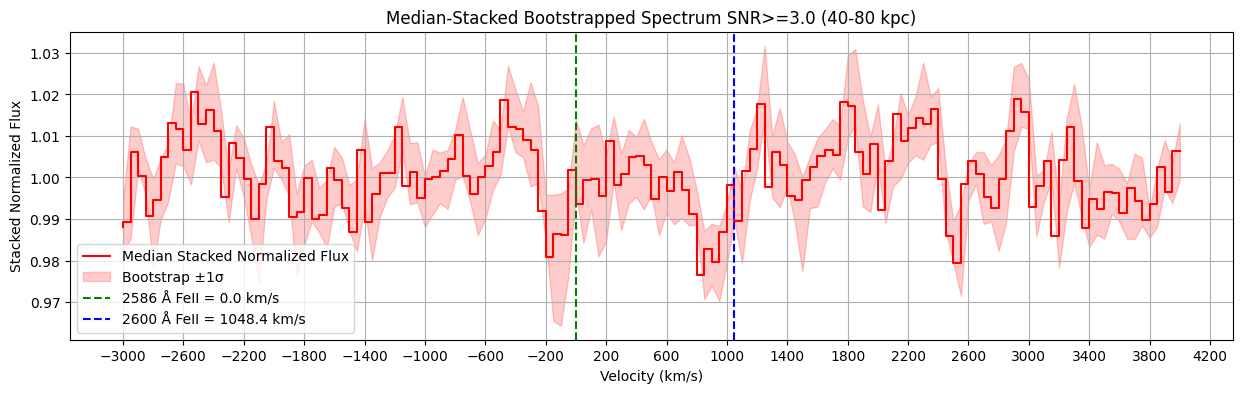

In [65]:
base_path = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /FeII_2374_2382/"
interpolated_dir = f"{base_path}interpolated_output{file_index}/"
stacked_file_boot = f"{base_path}stacked/median_stacked_boot_spectrum{file_index}.txt"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/FeII_2374_2382/"

os.makedirs(interpolated_dir, exist_ok=True)
os.makedirs(pic_dir, exist_ok=True)

# --- Load All Interpolated Flux ---
interpolated_files = [f for f in os.listdir(interpolated_dir) if f.endswith(".txt")]
if len(interpolated_files) == 0:
    print("No interpolated files found. Exiting.")
    exit()

velocity = np.loadtxt(os.path.join(interpolated_dir, interpolated_files[0]), skiprows=1)[:, 0]

all_flux = []
for file in interpolated_files:
    try:
        data = np.loadtxt(os.path.join(interpolated_dir, file), skiprows=1)
        all_flux.append(data[:, 1])
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")
        continue

all_flux = np.array(all_flux)
N = all_flux.shape[0]

# --- 1. Median Stacking and Bootstrapping for Error Estimation ---
B = 100
bootstrap_stacks = np.empty((B, all_flux.shape[1]))

for i in range(B):
    indices = np.random.choice(N, size=N, replace=True)
    resampled_fluxes = all_flux[indices, :]
    bootstrap_stacks[i, :] = np.nanmedian(resampled_fluxes, axis=0)

final_stacked_flux = np.nanmedian(bootstrap_stacks, axis=0)
lower_bound = np.nanpercentile(bootstrap_stacks, 16, axis=0)
upper_bound = np.nanpercentile(bootstrap_stacks, 84, axis=0)
error_lower = final_stacked_flux - lower_bound
error_upper = upper_bound - final_stacked_flux
## defines 68% confidence interval 


# Save the bootstrapped spectrum
np.savetxt(stacked_file_boot, np.column_stack((velocity, final_stacked_flux, error_lower, error_upper)),
           fmt="%.6f", delimiter="\t", header="Velocity\tStacked_Flux\tError_Lower\tError_Upper", comments='')

# --- 2. Plotting ---
sec_doublet_vel = ((fe2 - fe1) / fe1) * c

plt.figure(figsize=(15, 4))
plt.step(velocity, final_stacked_flux, 'r-', label="Median Stacked Normalized Flux", lw=1.5)
plt.fill_between(velocity, final_stacked_flux - error_lower, final_stacked_flux + error_upper,
                 color='red', alpha=0.2, label="Bootstrap ±1σ")
plt.axvline(0.0, color='green', lw=1.5, linestyle="--", label="2586 Å FeII = 0.0 km/s")
plt.axvline(sec_doublet_vel, color='blue', lw=1.5, linestyle="--", label=f"2600 Å FeII = {sec_doublet_vel:.1f} km/s")
plt.xlabel("Velocity (km/s)")
plt.xticks(np.arange(-3000, 4400, 400))
plt.ylabel("Stacked Normalized Flux")
plt.title(f"Median-Stacked Bootstrapped Spectrum SNR>={snr} ({sep_low}-{sep_up} kpc)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(pic_dir, f"median_stacked_bootstrapped_{file_index}.png"))
plt.show()


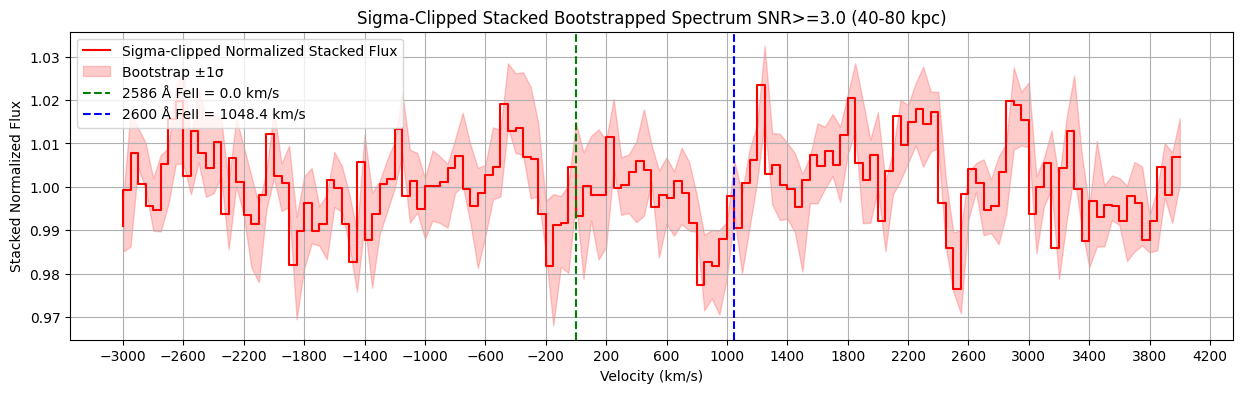

In [66]:
base_path = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /FeII_2374_2382/"
normalized_dir = f"{base_path}normalized_output{file_index}/"
interpolated_dir = f"{base_path}interpolated_output{file_index}/"
stacked_file_boot = f"{base_path}stacked/sigma-clipped_stacked_boot_spectrum{file_index}.txt"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/FeII_2374_2382/"

# Load all interpolated files
interpolated_files = [f for f in os.listdir(interpolated_dir) if f.endswith(".txt")]
if len(interpolated_files) == 0:
    print("No interpolated files found. Exiting.")
    exit()

first_file = np.loadtxt(os.path.join(interpolated_dir, interpolated_files[0]), skiprows=1)
velocity = first_file[:, 0]

all_flux = []
for file in interpolated_files:
    try:
        data = np.loadtxt(os.path.join(interpolated_dir, file), skiprows=1)
        all_flux.append(data[:, 1])
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")
        continue

all_flux = np.array(all_flux)
N = all_flux.shape[0]

# 1. --- Sigma-Clipped Median Stacking and Bootstrapping for Error Estimation ---
B = 100
bootstrap_stacks = np.empty((B, all_flux.shape[1]))
sigma_thresh = 3.0

for i in range(B):
    indices = np.random.choice(N, size=N, replace=True)
    resampled_fluxes = all_flux[indices, :]
    clipped_flux = sigma_clip(resampled_fluxes, sigma=sigma_thresh, axis=0, masked=False)
    bootstrap_stacks[i, :] = np.nanmedian(clipped_flux, axis=0)

final_stacked_flux = np.nanmedian(bootstrap_stacks, axis=0)
lower_bound = np.nanpercentile(bootstrap_stacks, 16, axis=0)
upper_bound = np.nanpercentile(bootstrap_stacks, 84, axis=0)
error_lower = final_stacked_flux - lower_bound
error_upper = upper_bound - final_stacked_flux

# Save bootstrapped spectrum
np.savetxt(stacked_file_boot, np.column_stack((velocity, final_stacked_flux, error_lower, error_upper)),
           fmt="%.6f", delimiter="\t", header="Velocity\tStacked_Flux\tError_Lower\tError_Upper", comments='')

# 3. --- Plotting Both ---
sec_doublet_vel = ((fe2 - fe1) / fe1) * c

plt.figure(figsize=(15,4))
plt.step(velocity, final_stacked_flux, 'r-', label="Sigma-clipped Normalized Stacked Flux", lw=1.5)
plt.fill_between(velocity, final_stacked_flux - error_lower, final_stacked_flux + error_upper,
                 color='red', alpha=0.2, label="Bootstrap ±1σ")
plt.axvline(0.0, color='green', lw=1.5, linestyle="--", label="2586 Å FeII = 0.0 km/s")
plt.axvline(sec_doublet_vel, color='blue', lw=1.5, linestyle="--", label=f"2600 Å FeII = {sec_doublet_vel:.1f} km/s")
plt.xlabel("Velocity (km/s)")
plt.xticks(np.arange(-3000, 4400, 400))
plt.ylabel("Stacked Normalized Flux")
plt.title(f"Sigma-Clipped Stacked Bootstrapped Spectrum SNR>={snr} ({sep_low}-{sep_up} kpc)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(pic_dir, f"sigma-clipped_stacked_bootstrapped_{file_index}.png"))
plt.show()


slope and y intercept of continum =  5.528268417487325e-07 1.0044441450314927


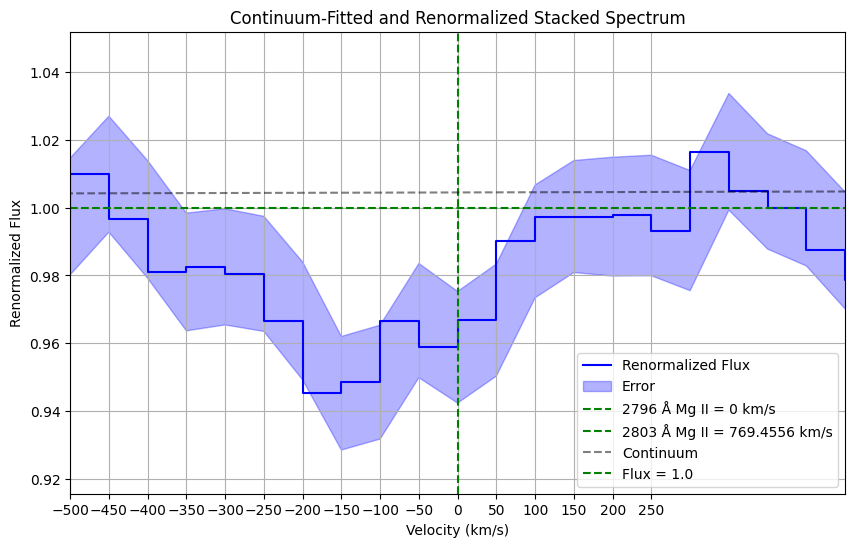

In [74]:
pic_dir = "/home/mehak/mehak/project/report/pics/velocity/"

# Linear function for fitting
def linear(x, a, b):
    return a * x + b

# Define continuum fitting regions
continuum_mask = ((velocity >= -3000) & (velocity <= -385)) | ((velocity >= 1155) & (velocity <= 3000))

# Fit the linear continuum to selected regions
cont_velocity = velocity[continuum_mask]
cont_flux = stacked_flux[continuum_mask]

# Fit linear function to continuum region
popt, _ = curve_fit(linear, cont_velocity, cont_flux)
continuum_fit = linear(velocity, *popt)
print("slope and y intercept of continum = ",*popt)

# Renormalize flux and error by continuum
renorm_flux = stacked_flux / continuum_fit
renorm_error = stacked_error / continuum_fit

# Plot renormalized stacked spectrum
plt.figure(figsize=(10, 6))
plt.step(velocity, renorm_flux, 'b-', label="Renormalized Flux", lw=1.5)
plt.fill_between(velocity, renorm_flux - renorm_error, renorm_flux + renorm_error, color='blue', alpha=0.3, label="Error")
plt.axvline(x=0.0, color='green', lw=1.5, linestyle="--", label="2796 Å Mg II = 0 km/s")
plt.axvline(x=sec_doublet_vel, color='green', lw=1.5, linestyle="--", label=f"2803 Å Mg II = {sec_doublet_vel:.4f} km/s")
plt.plot(velocity, continuum_fit , 'k--', label='Continuum', alpha=0.5)  # for visual reference
plt.axhline(y=1.0, color='green', lw=1.5, linestyle="--", label="Flux = 1.0")

# Labels and title
plt.xlabel("Velocity (km/s)")
plt.xlim(-500,500)
plt.ylabel("Renormalized Flux")
plt.xticks(np.arange(-500,300,50))
plt.title("Continuum-Fitted and Renormalized Stacked Spectrum")
plt.legend()
plt.grid(True)

# Save figure
pic_filepath_renorm = os.path.join(pic_dir, f"stacked{file_index}_renormalized.png")
#plt.savefig(pic_filepath)
plt.show()


Histogram saved to /home/mehak-gupta/mehak/project/report/pics/histogram_snr/median_sn_histogram7.png


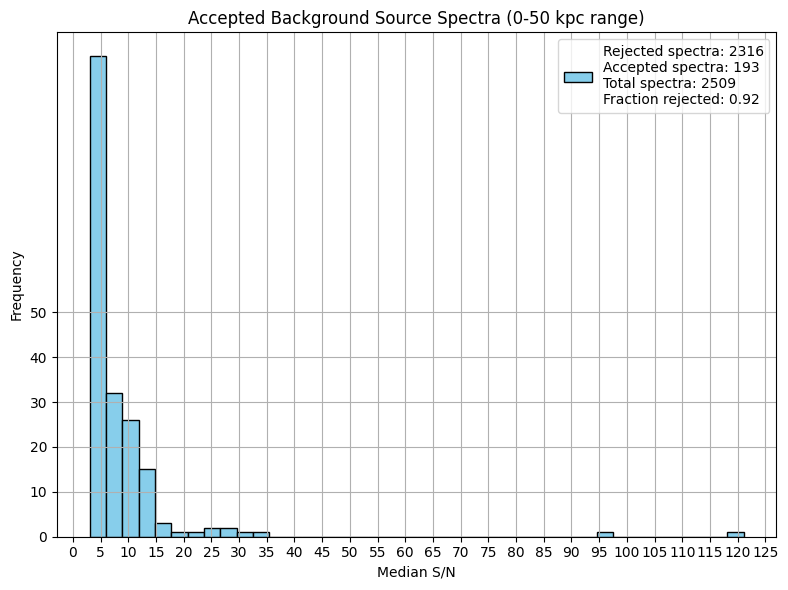

In [75]:
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/histogram_snr/"

tot=rejected+len(accepted_rows)
legend_text = (f"Rejected spectra: {rejected}\n"
    f"Accepted spectra: {len(accepted_rows)}\n"
    f"Total spectra: {tot}\n"
    f"Fraction rejected: {rejected/tot:.2f}")

# Plotting Histogram of Median S/N Values for Accepted bg source spectra
if accepted_median_sn:
    plt.figure(figsize=(8, 6))
    plt.hist(accepted_median_sn, bins=40, edgecolor='black', color='skyblue')
    plt.xticks(np.arange(0,130,step=5))
    plt.yticks(np.arange(0,60,step=10))
    plt.xlabel("Median S/N")
    plt.ylabel("Frequency")
    plt.title(f"Accepted Background Source Spectra ({sep_low}-{sep_up} kpc range)")
    plt.legend([legend_text])
    plt.grid(True)
    plt.tight_layout()
    
    #Save the histogram image:
    hist_filepath = os.path.join(pic_dir, f"median_sn_histogram{file_index}.png")
    #plt.savefig(hist_filepath)
    print(f"Histogram saved to {hist_filepath}")
    plt.show()
else:
    print("No accepted S/N values to plot a histogram.")


In [13]:
v= 1155#[3000,-385,1155,3000]

w= (v/c)*mg1+mg1 
print(w)

2807.1277171768256


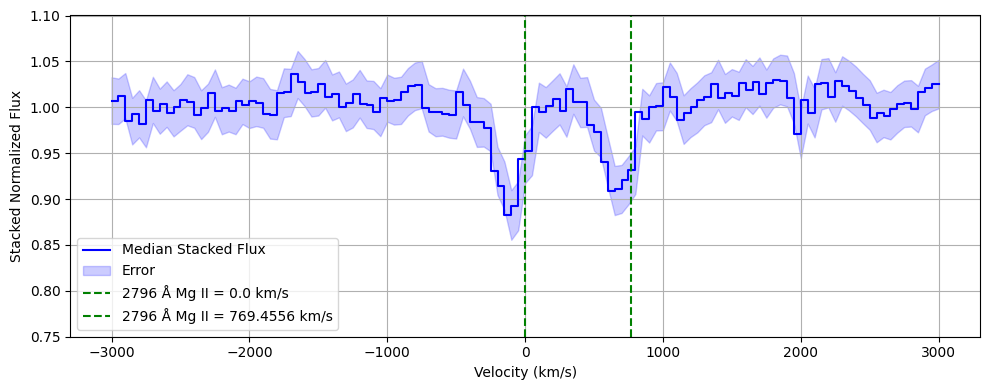

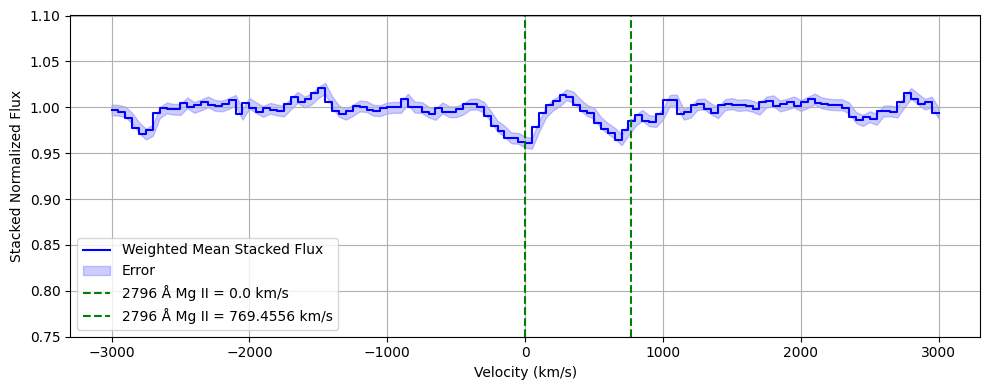

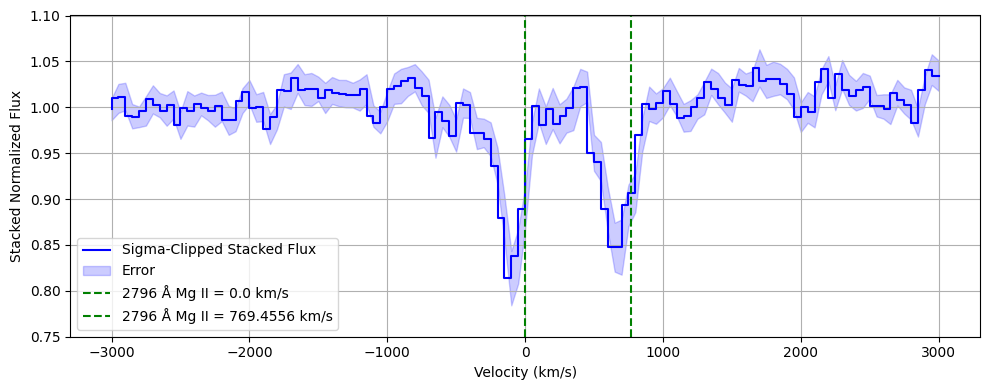

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

# === PATHS ===
interpolated_dir = f"/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/medfilt_cont/velocity/interpolated_output{file_index}/"
stacked_dir = f"/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/medfilt_cont/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"

stacked_file_median = os.path.join(stacked_dir, f"median_stacked_spectrum{file_index}.txt")
stacked_file_weighted = os.path.join(stacked_dir, f"weighted_mean_stacked_spectrum{file_index}.txt")
stacked_file_sigma = os.path.join(stacked_dir, f"stacked_spectrum_sigma_clipped{file_index}.txt")

# === LOAD FILES ===
interpolated_files = [f for f in os.listdir(interpolated_dir) if f.endswith(".txt")]

if len(interpolated_files) == 0:
    print("No interpolated files found. Exiting.")
    exit()

# Read first file for wavelength grid (skip header)
first_file = np.loadtxt(os.path.join(interpolated_dir, interpolated_files[0]), skiprows=1)
velocity = first_file[:, 0]

# Initialize lists for flux and error
all_flux = []
all_error = []

for file in interpolated_files:
    file_path = os.path.join(interpolated_dir, file)
    try:
        data = np.loadtxt(file_path, skiprows=1)
        all_flux.append(data[:, 1])   # Flux column
        all_error.append(data[:, 2])  # Error column
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")

all_flux = np.array(all_flux)
all_error = np.array(all_error)

# Replace inf and invalid values with NaN for safety
all_flux[~np.isfinite(all_flux)] = np.nan
all_error[~np.isfinite(all_error)] = np.nan
all_error[all_error <= 0] = np.nan  # no zero or negative errors allowed

fst_doublet_vel = 0.0
sec_doublet_vel = ((mg2-mg1)/mg1)*c

# ---- 1. MEDIAN STACKING ----
stacked_flux_median = np.nanmedian(all_flux, axis=0)
stacked_error_median = 1.253 * np.nanmedian(all_error, axis=0) / np.sqrt(len(interpolated_files))

stacked_spectrum_median = np.column_stack((velocity, stacked_flux_median, stacked_error_median))
np.savetxt(stacked_file_median, stacked_spectrum_median, fmt="%.6f", delimiter="\t",
           header="Velocity\tStacked_Flux_Median\tStacked_Error_Median", comments='')

# Plot median stacked spectrum
plt.figure(figsize=(10,4))
plt.step(velocity, stacked_flux_median, 'b-', label="Median Stacked Flux", lw=1.5)
plt.fill_between(velocity, stacked_flux_median - stacked_error_median,
                 stacked_flux_median + stacked_error_median, color='blue', alpha=0.2, label="Error")
plt.axvline(x=0.0, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {fst_doublet_vel} km/s")
plt.axvline(x=sec_doublet_vel, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {sec_doublet_vel:.4f} km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Stacked Normalized Flux")
plt.ylim(0.75, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, f"median_stacked_{file_index}.png"), dpi=300)
plt.show()

# ---- 2. WEIGHTED MEAN STACKING ----
weights = 1 / (all_error**2)
weights[np.isnan(weights)] = 0  # avoid NaNs in weights

# Weighted mean flux and error
stacked_flux_weighted = np.nansum(weights * all_flux, axis=0) / np.nansum(weights, axis=0)
stacked_error_weighted = 1 / np.sqrt(np.nansum(weights, axis=0))

stacked_spectrum_weighted = np.column_stack((velocity, stacked_flux_weighted, stacked_error_weighted))
np.savetxt(stacked_file_weighted, stacked_spectrum_weighted, fmt="%.6f", delimiter="\t",
           header="Velocity\tStacked_Flux_Weighted_Mean\tStacked_Error_Weighted_Mean", comments='')

# Plot weighted mean stacked spectrum
plt.figure(figsize=(10,4))
plt.step(velocity, stacked_flux_weighted, 'b-', label="Weighted Mean Stacked Flux", lw=1.5)
plt.fill_between(velocity, stacked_flux_weighted - stacked_error_weighted,
                 stacked_flux_weighted + stacked_error_weighted, color='blue', alpha=0.2, label="Error")
plt.axvline(x=0.0, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {fst_doublet_vel} km/s")
plt.axvline(x=sec_doublet_vel, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {sec_doublet_vel:.4f} km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Stacked Normalized Flux")
plt.ylim(0.75, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, f"weighted_mean_stacked_{file_index}.png"), dpi=300)
plt.show()

# ---- 3. SIGMA-CLIPPED MEAN STACKING ----
sigma_threshold = 3.0  # adjustable sigma clipping threshold
clipped_flux = sigma_clip(all_flux, sigma=sigma_threshold, axis=0, masked=False)

stacked_flux_sigma = np.nanmean(clipped_flux, axis=0)
stacked_error_sigma = np.nanstd(clipped_flux, axis=0) / np.sqrt(len(interpolated_files))

stacked_spectrum_sigma = np.column_stack((velocity, stacked_flux_sigma, stacked_error_sigma))
np.savetxt(stacked_file_sigma, stacked_spectrum_sigma, fmt="%.6f", delimiter="\t",
           header="Velocity\tStacked_Flux_Sigma_Clipped\tStacked_Error_Sigma_Clipped", comments='')

# Plot sigma-clipped stacked spectrum
plt.figure(figsize=(10, 4))
plt.step(velocity, stacked_flux_sigma, 'b-', label="Sigma-Clipped Stacked Flux", lw=1.5)
plt.fill_between(velocity, stacked_flux_sigma - stacked_error_sigma,
                 stacked_flux_sigma + stacked_error_sigma, color='blue', alpha=0.2, label="Error")
plt.axvline(x=0.0, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {fst_doublet_vel} km/s")
plt.axvline(x=sec_doublet_vel, color='green', lw=1.5, linestyle="--", label=f"2796 Å Mg II = {sec_doublet_vel:.4f} km/s")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Stacked Normalized Flux")
plt.ylim(0.75, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, f"sigma_clipped_stacked_{file_index}.png"), dpi=300)
plt.show()
